In [1]:
import os
from IPython.display import Image, display, Code
os.chdir('..')

import hydra
from omegaconf import DictConfig, OmegaConf

from chemtorch.utils import DataSplit, load_model, set_seed
from chemtorch.utils.hydra import safe_instantiate

OmegaConf.register_new_resolver("eval", eval)

# ChemTorch

## How to add a new dataset

#### 1. Drag and drop you dataset into the `data` folder, e.g.: "data/e2/barriers/forward/data.csv"
#### 2. Create a config file in the `conf/data_ingestor` folder
```yaml
# conf/data_ingestor/e2.yaml
_target_: chemtorch.data_ingestor.SimpleDataIngestor

defaults:
  - data_source: single_csv_source                          # how to read the data
  - column_mapper: column_filter_and_rename                 # how to map the columns    
  - data_splitter: ratio_splitter                           # how to split the data 

data_source:
  data_path: "data/e2/barriers/forward/data.csv"

column_mapper:
  column_mapping:
    smiles: "smiles"
    label: "ea"

data_splitter:
  train_ratio: 0.9
  val_ratio: 0.05
  test_ratio: 0.05
```
#### 3. Run in command line (or change in config file or make a new config file):
```bash
python scripts/main.py +experiment=graph dataset.subsample=0.05 data_ingestor=e2
```


## How to add your own model

#### 1. Drag and drop you model.py into the `src/chemtorch/model` folder, e.g.: "src/chemtorch/model/gat.py"
#### 2. Create a config file in the `conf/model/` folder
```yaml
# conf/model/gat.yaml
_target_: chemtorch.model.gnn.GNN

defaults:
  - encoder: linear_enc
  - layer_stack: layer_stack
  - layer_stack/gnn_block/gat_block@layer_stack.layer
  - pool: global_pool
  - head: mlp

hidden_channels: 64
```
#### 3. Run in command line (or change in config file or make a new config file):
```bash
python scripts/main.py +experiment=graph dataset.subsample=0.05 model=gat
```

## Simple sweeps

```bash
python scripts/main.py --multirun +experiment=graph dataset.subsample=0.05 model=gat,dmpnn data_ingestor=e2,sn2
```

## Override parameters

```bash
python scripts/main.py --multirun +experiment=graph dataset.subsample=0.05 model=gat data_ingestor=e2 dataset/transform=randomwalk model/encoder=rwpe_and_linear_enc model.hidden_channels=128
```

## General functionalities

### Main config file

```yaml
# conf/config.yaml 
defaults:
  - data_ingestor: rdb7_fwd
  - dataset: graph
  - dataloader: pyg_dataloader
  - model: dmpnn
  - routine: regression
  - _self_

# other global parameters ...
```

### Data Pipeline: Data Ingestor, Dataset, Dataloader

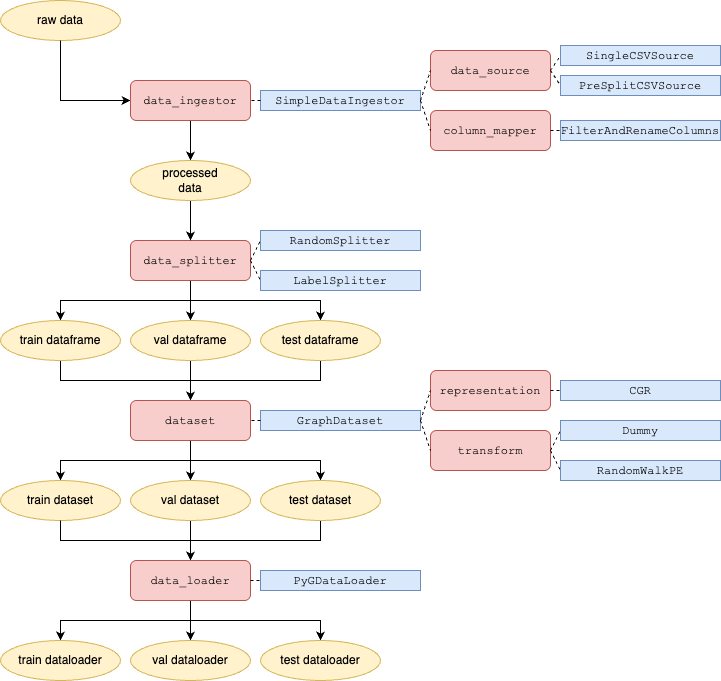

In [2]:
Image(filename='images/simple_data_pipeline.png', width=800, height=600)

### Example: Data Ingestor

```yaml
# conf/data_ingestor/rdb7_fwd.yaml
_target_: chemtorch.data_ingestor.SimpleDataIngestor

defaults:
  - data_source: single_csv_source
  - column_mapper: column_filter_and_rename
  - data_splitter: ratio_splitter

data_source:
  data_path: "data/rdb7/barriers/forward/data.csv"

column_mapper:
  column_mapping:
    smiles: "smiles"
    label: "dE0"

data_splitter:
  train_ratio: 0.9
  val_ratio: 0.05
  test_ratio: 0.05
```

### Example: Data Source, Column Mapper, and Data Splitter

```yaml
# conf/data_ingestor/data_source/single_csv_source.yaml
_target_: chemtorch.data_ingestor.data_source.SingleCSVSource
data_path: null

# conf/data_ingestor/column_mapper/column_filter_and_rename.yaml
_target_: chemtorch.data_ingestor.column_mapper.ColumnFilterAndRename
column_mapping: null

# conf/data_ingestor/data_splitter/ratio_splitter.yaml
_target_: chemtorch.data_ingestor.data_splitter.RatioSplitter 
train_ratio: null
val_ratio: null
test_ratio: null

### Hydra as configuration tool

#### config.yaml defines the structure of the configuration and points to default choices. The actual values are usually defined in the conf/experiment/ folder.

```yaml
# conf/experiment/gnn.yaml
# @package _global_
defaults:
  - override /data_ingestor: rdb7_fwd_rev_spiekermann
  - override /dataset: graph
  - override /dataloader: pyg_dataloader
  - override /model: dmpnn
  - override /routine: regression
  - _self_
# other global parameters ...
```

In [3]:
# code below analogous to
# python scripts/main.py +experiment=gnn
with hydra.initialize(version_base=None, config_path="../conf"):
    overrides = [
        "data_ingestor=rdb7_fwd",
        "dataset=graph",
        "dataloader=pyg_dataloader",
        "model=dmpnn",
        "routine=regression",
        "log=false",
        "runtime_args_from_train_dataset_props=[num_node_features,num_edge_features,mean,std]",
        "dataset.subsample=0.05"
    ]
    
    cfg = hydra.compose(config_name="config", overrides=overrides)

OmegaConf.set_struct(cfg, False)
print(OmegaConf.to_yaml(cfg))

data_ingestor:
  data_source:
    _target_: chemtorch.data_ingestor.data_source.SingleCSVSource
    data_path: data/rdb7/barriers/forward/data.csv
  column_mapper:
    _target_: chemtorch.data_ingestor.column_mapper.ColumnFilterAndRename
    column_mapping:
      smiles: smiles
      label: dE0
  data_splitter:
    _target_: chemtorch.data_ingestor.data_splitter.RatioSplitter
    train_ratio: 0.9
    val_ratio: 0.05
    test_ratio: 0.05
  _target_: chemtorch.data_ingestor.SimpleDataIngestor
dataset:
  representation:
    atom_featurizer:
      _target_: chemtorch.featurizer.FeaturizerCompose
      featurizers:
      - _target_: chemtorch.featurizer.OrganicAtomicNumberOneHotFeaturizer
      - _target_: chemtorch.featurizer.AtomDegreeFeaturizer
      - _target_: chemtorch.featurizer.AtomFormalChargeFeaturizer
      - _target_: chemtorch.featurizer.AtomHCountFeaturizer
      - _target_: chemtorch.featurizer.AtomHybridizationFeaturizer
      - _target_: chemtorch.featurizer.AtomIsAromaticF

### Code in main.py

In [4]:
##### DATA INGESTOR #########################################################
data_ingestor = safe_instantiate(cfg.data_ingestor)
print(f"INFO: Data ingestor instantiated successfully")
dataframes = data_ingestor()
print(f"INFO: Data ingestor finished successfully")

##### DATA MODULE ###########################################################
dataset_factory = safe_instantiate(cfg.dataset)
print(f"INFO: Data module factory instantiated successfully")
datasets = DataSplit(*map(lambda df: dataset_factory(df), dataframes))
print(f"INFO: Data modules instantiated successfully")

##### DATALOADERS ###########################################################
train_loader = safe_instantiate(
    cfg.dataloader,
    dataset=datasets.train,
    shuffle=True,
)
val_loader = safe_instantiate(
    cfg.dataloader,
    dataset=datasets.val,
    shuffle=False,
)
test_loader = safe_instantiate(
    cfg.dataloader,
    dataset=datasets.test,
    shuffle=False,
)

INFO: Data ingestor instantiated successfully
INFO: Data ingestor finished successfully
INFO: Data module factory instantiated successfully
INFO: Precomputing 537 items...
INFO: Precomputation finished in 0.87s.
INFO: Precomputing 30 items...
INFO: Precomputation finished in 0.05s.
INFO: Precomputing 30 items...
INFO: Precomputation finished in 0.05s.
INFO: Data modules instantiated successfully


## Workflow

### E.g., I want to use the same settings but different dataset
### Option 1: change config files directly (or make a new config file)

```yaml
# conf/experiment/gnn.yaml
# @package _global_
defaults:
  - override /data_ingestor: e2             # changed from rdb7_fwd_rev_spiekermann to e2
  - override /dataset: graph
  - override /dataloader: pyg_dataloader
  - override /model: dmpnn
  - override /routine: regression
  - _self_
# other global parameters ...
```

### Option 2: use command line to override config

```bash
python scripts/main.py +experiment=gnn data_ingestor=e2
```

In [5]:
# code below analogous to
# python scripts/main.py +experiment=gnn data_ingestor=e2
with hydra.initialize(version_base=None, config_path="../conf"):
    overrides = [
        "data_ingestor=e2",
        "dataset=graph",
        "dataloader=pyg_dataloader",
        "model=dmpnn",
        "routine=regression",
        "log=false",
        "runtime_args_from_train_dataset_props=[num_node_features,num_edge_features,mean,std]",
        "dataset.subsample=0.05"
    ]
    
    cfg = hydra.compose(config_name="config", overrides=overrides)

OmegaConf.set_struct(cfg, False)
print(OmegaConf.to_yaml(cfg))

data_ingestor:
  data_source:
    _target_: chemtorch.data_ingestor.data_source.SingleCSVSource
    data_path: data/e2/barriers/forward/data.csv
  column_mapper:
    _target_: chemtorch.data_ingestor.column_mapper.ColumnFilterAndRename
    column_mapping:
      smiles: smiles
      label: ea
  data_splitter:
    _target_: chemtorch.data_ingestor.data_splitter.RatioSplitter
    train_ratio: 0.9
    val_ratio: 0.05
    test_ratio: 0.05
  _target_: chemtorch.data_ingestor.SimpleDataIngestor
dataset:
  representation:
    atom_featurizer:
      _target_: chemtorch.featurizer.FeaturizerCompose
      featurizers:
      - _target_: chemtorch.featurizer.OrganicAtomicNumberOneHotFeaturizer
      - _target_: chemtorch.featurizer.AtomDegreeFeaturizer
      - _target_: chemtorch.featurizer.AtomFormalChargeFeaturizer
      - _target_: chemtorch.featurizer.AtomHCountFeaturizer
      - _target_: chemtorch.featurizer.AtomHybridizationFeaturizer
      - _target_: chemtorch.featurizer.AtomIsAromaticFeat